In [57]:
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import heapq
import pycbc.waveform
from pycbc.types import FrequencySeries
%matplotlib inline
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

In [22]:
def unlensed_waveform(**args):
    
    theta_s = args['theta_s']
    phi_s = args['phi_s']
    theta_l = args['theta_l']
    phi_l = args['phi_l']
    mcz = args['mcz']
    dist = args['dist']
    eta = args['eta']
    tc = args['tc']
    phi_c = args['phi_c']
    flow = args['f_lower']
    
    df = args['delta_f']
    
    def limit(mcz, eta):
        low_limit = 20
        f_cut = 1 / (np.power(6, 3/2) * np.pi * ((mcz) / (np.power(eta, 3/5))))
        return low_limit, f_cut
   
    f = np.arange(flow, limit(mcz, eta)[1], df)

    """
    This file is just functionized form of L_unlensed(which was "object-oriented"). This was mainly created
    for the optimization of overlap function.
    """
    def mass_conv(mcz, eta):
        """Converts chirp mass to total mass. M = mcz/eta^(3/5)
        """

        M_val = mcz/np.power(eta, 3/5)
        return M_val

    def l_dot_n(theta_s, theta_l, phi_s, phi_l):
        """TODO
        """

        cos_term = np.cos(theta_s) * np.cos(theta_l)
        sin_term = np.sin(theta_s) * np.sin(theta_l) * np.cos(phi_s - phi_l)

        inner_prod = cos_term + sin_term
        return inner_prod

    def amp(mcz, dist):
        """TODO
        """

        amplitude = np.sqrt(5 / 96) * np.power(np.pi, -2 / 3) * np.power(mcz, 5 / 6) / (dist)
        return amplitude

    def psi(f, tc, phi_c, mcz, eta):
        """eqn 3.13 in Cutler-Flanaghan 1994
        """

        front_terms = 2 * np.pi * f * tc - phi_c - np.pi / 4
        main_coeffs = 0.75 * np.power(8 * np.pi * mcz * f, -5 / 3)
        main_terms = (1 + 20 / 9 * (743 / 336 + 11 / 4 * eta) * np.power(np.pi * mass_conv(mcz, eta) * f, 2 / 3)
                        - (16 * np.pi) * np.power(np.pi * mass_conv(mcz, eta) * f, 1))

        psi_val = front_terms + main_coeffs * (main_terms)
        return psi_val

    def psi_s(theta_s, theta_l, phi_s, phi_l):

        numerator = np.cos(theta_l)-np.cos(theta_s)*(l_dot_n(theta_s, theta_l, phi_s, phi_l))
        denominator = np.sin(theta_s)*np.sin(theta_l)*np.sin(phi_l-phi_s)

        psi_s_val = np.arctan2(numerator, denominator)
        return psi_s_val


    def fIp(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)* np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)* np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIp_val = term_1 - term_2
        return fIp_val

    def fIc(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)
                    * np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)
                    * np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIc_val = term_1 + term_2
        return fIc_val

    def lambdaI():
        """TODO
        """

        term_1 = np.power(2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s), 2)
        term_2 = np.power((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s), 2)

        lambdaI_val = np.sqrt(term_1 + term_2)
        return lambdaI_val

    def phi_pI():
        """TODO
        """

        numerator = (2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s))
        denominator = ((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s))

        phi_pI_val = np.arctan2(numerator, denominator)
        return phi_pI_val

    term_1 = lambdaI()
    term_2 = (np.exp(-1j * phi_pI()))
    term_3 = amp(mcz, dist) * np.power(f, -7 / 6)
    term_4 = np.exp(1j * psi(f, tc, phi_c, mcz, eta))

    signal_I = term_1 * term_2 * term_3 * term_4
    
    signal_I = FrequencySeries(signal_I, delta_f = df)
    return signal_I, f

In [23]:
pycbc.waveform.add_custom_waveform('unlensed', unlensed_waveform, 'frequency', force=True)

In [24]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec

hf, f = pycbc.waveform.get_fd_waveform(approximant="unlensed",
                                        theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0, 
                                        mcz = 18.79 * solar_mass, dist = 1.58 * giga_parsec, eta = 0.25,
                                        tc = 0, phi_c = 0,
                                        delta_f=1/4, f_lower = 20)

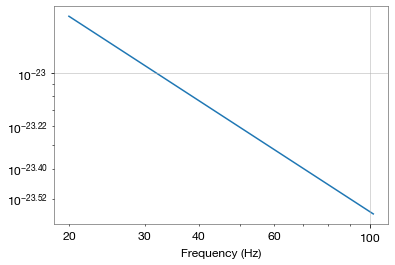

In [25]:
pp.figure(1)
pp.loglog(f, np.abs(hf))
#pp.loglog(f, f ** (-7/3))
pp.xlabel('Frequency (Hz)')
#pp.xscale('log')
#pp.xlim(20, 100)
pp.show()

### Trying SIS lens in GO regime

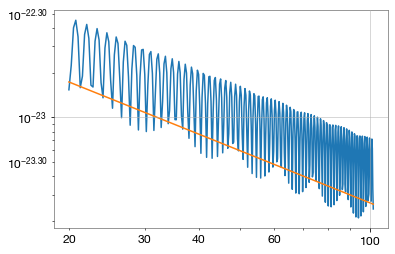

In [26]:
def amplification_factor(y, ML):
    mu_plus = 1 + 1 / y
    mu_minus = -1 + 1 / y
    td = 8 * ML * y
    amp_factor = np.sqrt(np.abs(mu_plus)) - 1j * np.sqrt(np.abs(mu_minus)) * np.exp(2 * np.pi * 1j * f * td)
    return amp_factor

hf_lensed = amplification_factor(0.5, 3.98106811e+04 * solar_mass) * hf
pp.loglog(f, np.abs(hf_lensed))
pp.loglog(f, np.abs(hf))

### Trying differest PSDs

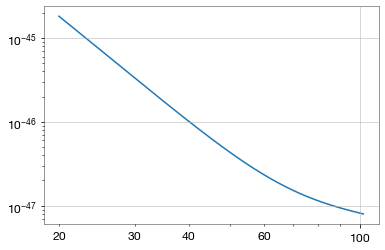

In [27]:
def Sn(f):
        """From table 1 of arXiv:0903.0338. Changed from iLIGO to aLIGO.
        """
        fs = 20
        if f < fs:
            Sn_val = np.inf
        else:
            S0 = 1E-49
            f0 = 215
            Sn_temp = np.power(f/f0, -4.14) - 5 * np.power(f/f0, -2) + 111 * ((1 - np.power(f/f0, 2) + 0.5 * np.power(f/f0, 4)) / (1 + 0.5 * np.power(f/f0, 2)))
            Sn_val = Sn_temp * S0

        return Sn_val
    
psd_analytical = np.zeros_like(f)
for i in range(len(f)):
    psd_analytical[i] = Sn(f[i])
psd_analytical = FrequencySeries(psd_analytical, delta_f = 1/4)
pp.loglog(f, psd_analytical)

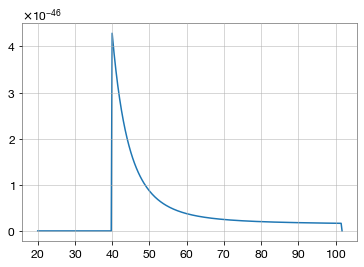

In [28]:
# Generate the aLIGO ZDHP PSD
delta_f = 1/4
flen = len(f)
f_low = 20
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
pp.plot(f, psd)

In [29]:
m, i = match(hf, hf_lensed, psd=psd_analytical, low_frequency_cutoff=20)
m, 1 - m

(0.8660463608208335, 0.13395363917916647)

### Trying two effective images out of four images in SIE

In [31]:
def amplification_factor_source(mu_c, mu_d, td_c, td_d):
    amp_factor_source = - 1j * np.sqrt(np.abs(mu_c)) * np.exp(2 * np.pi * 1j * f * td_c) - 1j * np.sqrt(np.abs(mu_d)) * np.exp(2 * np.pi * 1j * f * td_d)
    return amp_factor_source

In [32]:
def amplification_factor_template(mu_a, mu_b, td_a, td_b):
    amp_factor_template = np.sqrt(np.abs(mu_a)) * np.exp(2 * np.pi * 1j * f * td_a) - 1j * np.sqrt(np.abs(mu_b)) * np.exp(2 * np.pi * 1j * f * td_b)
    return amp_factor_template

In [33]:
td_c = 0.14699258
td_d = 0.20075049
mu_c = -6.715939
mu_d = -5.511535

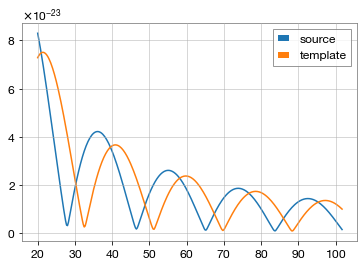

In [34]:
hf_L_source = hf * amplification_factor_source(mu_c, mu_d, td_c, td_d)
hf_L_template = hf * amplification_factor_template(mu_c, mu_d, td_c, td_d)
pp.plot(f, np.abs(hf_L_source), label = 'source')
pp.plot(f, np.abs(hf_L_template), label = 'template')
pp.legend()

In [35]:
m, i = match(hf_L_source, hf_L_template, psd=psd_analytical, low_frequency_cutoff=20)
m, 1 - m

(0.7255425360501528, 0.27445746394984716)

### Trying four images out of four  in SIE

In [36]:
def amplification_factor_source_fourimgs(mu_a, mu_b, mu_c, mu_d, td_a, td_b, td_c, td_d):
    amp_factor_source = np.sqrt(np.abs(mu_a)) * np.exp(2 * np.pi * 1j * f * td_a) + np.sqrt(np.abs(mu_b)) * np.exp(2 * np.pi * 1j * f * td_b) \
                        - 1j * np.sqrt(np.abs(mu_c)) * np.exp(2 * np.pi * 1j * f * td_c) - 1j * np.sqrt(np.abs(mu_d)) * np.exp(2 * np.pi * 1j * f * td_d)
    return amp_factor_source

In [37]:
mu_a = 6.848177  
mu_b = 9.048417 
mu_c = -8.200782
mu_d = -4.896159
td_a = 0.         
td_b = 0.07967972 
td_c = 0.14030047 
td_d = 0.27048972

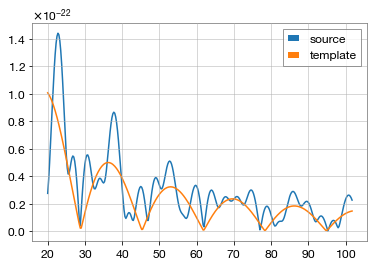

In [42]:
hf_L_source_4imgs = hf * amplification_factor_source_fourimgs(mu_a, mu_b, mu_c, mu_d, td_a, td_b, td_c, td_d)
hf_L_template = hf * amplification_factor_template(mu_b, mu_c, td_b, td_c)
pp.plot(f, np.abs(hf_L_source_4imgs), label = 'source')
pp.plot(f, np.abs(hf_L_template), label = 'template')
pp.legend()

In [43]:
m, i = match(hf_L_source_4imgs, hf_L_template, psd=psd_analytical, low_frequency_cutoff=20)
m, 1 - m

(0.7619161324632675, 0.2380838675367325)

### Calculating mismatches in four images case in SIE lens

Calculating $\epsilon$ in four images case in SIE lens as a function of $y$ for different angles. We are using lensed templates.

In [48]:
datPath = "/Users/saifali/Desktop/gwlensing/SIE_glafic/data/"
fileName = "flux_fourimages_theta_60_sigma=6_sorted_preproc.csv"

In [88]:
df_data = pd.read_csv(datPath + fileName)
radius_range = np.array(df_data['source_x'])

In [85]:
def amplification_factor_s(mu_arr, td_arr):
    F_source = np.sqrt(np.abs(mu_arr[0])) * np.exp(2 * np.pi * 1j * f * td_arr[0]) + np.sqrt(np.abs(mu_arr[1])) * np.exp(2 * np.pi * 1j * f * td_arr[1]) \
               - 1j * np.sqrt(np.abs(mu_arr[2])) * np.exp(2 * np.pi * 1j * f * td_arr[2]) - 1j * np.sqrt(np.abs(mu_arr[3])) * np.exp(2 * np.pi * 1j * f * td_arr[3])
    return F_source

def amplification_factor_t(mu_arr, td_arr):
    
    mu_1 = mu_arr[0]
    mu_2 = mu_arr[1]
    mu_3 = mu_arr[2]
    mu_4 = mu_arr[3]
    td_1 = td_arr[0]
    td_2 = td_arr[1]
    td_3 = td_arr[2]
    td_4 = td_arr[3]
    if len(set(mu_arr)) == 1:
            F_temp = np.array([0])

    # for one image case
    elif len(set(mu_arr)) == 2:
        F_temp = np.array([1])

    # for [1, 4] image pair case
    elif mu_arr[0] != 0 and mu_arr[-1] != 0 and mu_arr[1] == mu_arr[2] == 0:
        F_temp = np.sqrt(np.abs(mu_1)) * np.exp(2 * np.pi * 1j * f * td_1) - 1j * np.sqrt(np.abs(mu_4)) * np.exp(2 * np.pi * 1j * f * td_4)

    # for [3, 4] image pair case
    elif mu_arr[-2] != 0 and mu_arr[-1] != 0 and mu_arr[0] == mu_arr[1] == 0:
        F_temp = np.sqrt(np.abs(mu_3)) * np.exp(2 * np.pi * 1j * f * td_3) - 1j * np.sqrt(np.abs(mu_4)) * np.exp(2 * np.pi * 1j * f * td_4)

    # for [1, 2] image pair case
    elif mu_arr[0] != 0 and mu_arr[1] != 0 and mu_arr[2] == mu_arr[3] == 0:
        F_temp = np.sqrt(np.abs(mu_1)) * np.exp(2 * np.pi * 1j * f * td_1) - 1j * np.sqrt(np.abs(mu_2)) * np.exp(2 * np.pi * 1j * f * td_2)

    # for [1, 2, 3, 4] case
    else:
        mu_arr = np.array(mu_arr)
        td_arr = np.array(td_arr)
        mu_arr_abs = np.abs(mu_arr)
        largest_mus = heapq.nlargest(2, mu_arr_abs)
        index_1 = np.where(largest_mus[0] == mu_arr_abs)
        index_2 = np.where(largest_mus[1] == mu_arr_abs)
        mu_a = mu_arr[index_1]
        mu_b = mu_arr[index_2]
        td_a = td_arr[index_1]
        td_b = td_arr[index_2]
        F_temp = np.sqrt(np.abs(mu_a))  - 1j * np.sqrt(np.abs(mu_b)) * np.exp(2 * np.pi * 1j * f * np.abs(td_b - td_a))

    return F_temp

In [99]:
mu_arr = np.array(df_data.loc[6][1:5])
td_arr = np.array(df_data.loc[6][5:])
hf_lensed_source = hf * amplification_factor_s(mu_arr, td_arr)
hf_lensed_template = hf * amplification_factor_t(mu_arr, td_arr)

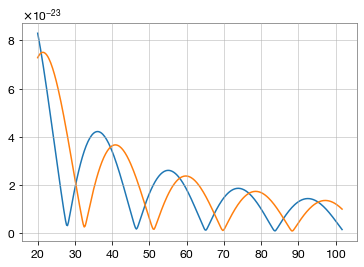

In [100]:
pp.plot(f, np.abs(hf_lensed_source))
pp.plot(f, np.abs(hf_lensed_template))

In [101]:
m, i = match(hf_lensed_source, hf_lensed_template, psd=psd_analytical, low_frequency_cutoff=20)
m

0.7255425634590712